# Multi-modal Fine-tuning - Smol VLM

Built by [Trelis.com](https://Trelis.com). Find us on [HuggingFace](https://huggingface.co/Trelis) and [GitHub](https://github.com/TrelisResearch).

This is a private notebook - available for purchase from Trelis.com .

---

Inspired by a base notebook available from HuggingFace [here](https://github.com/huggingface/smollm/blob/main/vision/finetuning/Smol_VLM_FT.ipynb).

---

## Getting Set Up
### Setup on an Ampere GPU (A40, A6000, A100, H100) with Cuda 12.1 and Pytorch 2.2.1 - RECOMMENDED.
Ampere architecture GPUs allow for the use of Flash Attention, which provides a speed up. Otherwise, you need to train with fp16 instead of bf16.

For the best reproducibility, run this script on an A40:
- Runpod one-click template [here](https://runpod.io/gsc?template=ifyqsvjlzj&ref=jmfkcdio) - easier setup.
- Vast.ai one-click template [here](https://cloud.vast.ai/?ref_id=98762&creator_id=98762&name=Fine-tuning%20Notebook%20by%20Trelis%20-%20Cuda%2012.1) - offers smaller GPUs (which are cheaper to run).

### GPU requirements for training
- You can train the smallest model with less than 8 GB of VRAM. Potentially you can even fine-tune on a Mac M1/2/3/4.

# Setup

We first setup the environment with the primary necessary libraries and login into Hugging Face.

In [ ]:
!python -m pip install --upgrade pip -q
!pip install -qU transformers
!pip install -qU accelerate datasets peft bitsandbytes hf_transfer tensorboard

# Can be a good idea to re-start the kernel after this

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.6 MB/s eta 0:00:00


In [ ]:
!pip install ninja -qU

In [ ]:
!pip install flash_attn==2.7.3 -q

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'flash_attn' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'flash_attn'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [ ]:
# !pip freeze > requirements.txt

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import Idefics3ForConditionalGeneration, AutoProcessor
from peft import PeftModel
import torch

device = "cuda"

# Load base model (Idefics3) before LoRA injection
base = Idefics3ForConditionalGeneration.from_pretrained(
    "HuggingFaceTB/SmolVLM-500M-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Inject LoRA adapter weights
CKPT_PATH = "/content/drive/MyDrive/SMOLVLM/checkpoint-5004"
model = PeftModel.from_pretrained(base, CKPT_PATH).to(device).eval()

# Load processor
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.55M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

In [ ]:
pip install datasets

# Loading the model and the dataset

We load the model from the Hugging Face hub.

Fine-tuning will be done on a small chess dataset.

In [ ]:
# Enable fast weights download and upload
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" # if you're connected to multiple gpus but only want to use one.

In [ ]:
# !pip uninstall flash-attn -y

In [ ]:
import torch
from PIL import Image
from transformers import Idefics3ForConditionalGeneration, AutoProcessor
from transformers import BitsAndBytesConfig

# NOTE THESE MODELS WILL STRUGGLE WITH MORE THAN ONE IMAGE.
# model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
model_id = "HuggingFaceTB/SmolVLM-500M-Instruct"

DEVICE = "cuda" # or "mps" for mac

# Define the quantization configuration with NF4 and double quantization
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,             # Use 4-bit quantization (NF4)
    bnb_4bit_quant_type="nf4",     # Set quantization type to NF4
    bnb_4bit_use_double_quant=True # Enable double quantization
)

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16, #float16 for colab
    device_map='auto',
    _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager",
    # quantization_config=quant_config, # to use quantization
)
processor = AutoProcessor.from_pretrained(model_id)

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

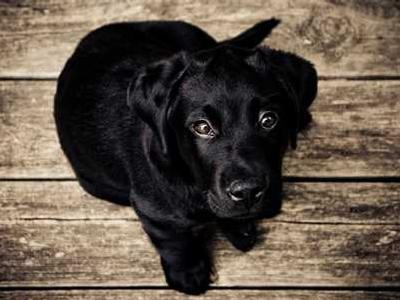

<|im_start|>User: Describe the images, one by one:<image><end_of_utterance>
Assistant:
User: Describe the images, one by one:




Assistant: A black labrador retriever sitting on a wooden surface looking up at the camera.


In [ ]:
from PIL import Image
from io import BytesIO
import requests
from transformers.image_utils import load_image

# Image URLs
IMG_URLS = [
    "https://picsum.photos/id/237/400/300",
    # "https://picsum.photos/id/231/200/300",
    # "https://picsum.photos/id/27/500/500",
    # "https://picsum.photos/id/17/150/600",
]

images = [load_image(url) for url in IMG_URLS]

# Display each image
for i, img in enumerate(images):
    img.show(title=f"Image {i + 1}")

# Your prompt
PROMPT = "Describe the images, one by one:"

messages = [
    {"role": "user", "content": [
        {"type": "text", "text": PROMPT},
        {"type": "image"},
        # {"type": "image"},
        # {"type": "image"},
        # {"type": "image"},
    ]}
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

print(input_text)

# Prepare the processor inputs
inputs = processor(text=input_text, images=images, return_tensors="pt").to("cuda")

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

In [ ]:
# processor.tokenizer.model_max_length=4096 # to reduce VRAM
print(processor.tokenizer.model_max_length)

8192


In [ ]:
# # not needed
# processor.tokenizer.pad_token = processor.tokenizer.eos_token

# # not needed
# processor.tokenizer.padding_side = "left"

In [ ]:
# TEST FORMATTING
# Example conversation input with user and assistant roles. Just to test the chat template.
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What do you see in this image?"},
            {"type": "image"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "This is a chessboard with pieces."}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What pieces do you see?"}
        ]
    }
]

# Apply the chat template to format the messages
formatted_text = processor.apply_chat_template(messages, add_generation_prompt=False)

# Output the formatted text
print("Formatted text:\n", formatted_text)

Formatted text:
 <|im_start|>User: What do you see in this image?<image><end_of_utterance>
Assistant: This is a chessboard with pieces.<end_of_utterance>
User: What pieces do you see?<end_of_utterance>



## Load Dataset

In [ ]:
# # HF example dataset. Note that you need to select the english query - see dataset prep below.
# from datasets import load_dataset

# train_dataset = load_dataset("nielsr/docvqa_1200_examples", split="train")
# train_dataset = train_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

# eval_dataset = load_dataset("nielsr/docvqa_1200_examples", split="test")
# eval_dataset = eval_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

In [ ]:
from datasets import load_dataset

# load and prepare dataset
ds = load_dataset("Trelis/chess_pieces")

train_dataset = ds["train"]
eval_dataset = ds["test"]

README.md:   0%|          | 0.00/413 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.3M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.41M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/48 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset

# load and prepare dataset
ds = load_dataset("racho1/2025")

train_dataset = ds["train"]
eval_dataset = ds["test"]

README.md:   0%|          | 0.00/433 [00:00<?, ?B/s]

train-00000-of-00015.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

train-00001-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

test-00000-of-00004.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

test-00001-of-00004.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

test-00002-of-00004.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

test-00003-of-00004.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/80091 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17277 [00:00<?, ? examples/s]

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 0.  install deps (Colab: Run once)
# ────────────────────────────────────────────────────────────────────────────────
!pip install -q --upgrade "datasets[pandas]" pillow tqdm

# ----  Un‑comment if you want to push back to Hub  ----
# !pip install -q "huggingface_hub[cli]>=0.20"
# !huggingface-cli login   # ⟵ paste your HF token with write access
# ────────────────────────────────────────────────────────────────────────────────


# ────────────────────────────────────────────────────────────────────────────────
# 1.  load the dataset with raw bytes
# ────────────────────────────────────────────────────────────────────────────────
from datasets import load_dataset, Image
from PIL import Image as PILImage, ImageFile, UnidentifiedImageError
import io, tqdm, os, json

ImageFile.LOAD_TRUNCATED_IMAGES = True  # ignore truncated JPEG bit‑streams

DATASET_NAME  = "racho1/2025"      # original repo
SPLIT         = "train"                 # adjust if you have others
LOCAL_CLEAN   = "Clef_2025_clean"       # output folder
PUSH_TO_HUB   = False                   # set True to push back

print("→ loading dataset (decode=False)…")
ds = load_dataset(DATASET_NAME, split=SPLIT, streaming=False)
ds = ds.cast_column("image", Image(decode=False))   # ⇐ raw bytes


# ────────────────────────────────────────────────────────────────────────────────
# 2.  find offending rows (UnicodeDecodeError, truncated, etc.)
# ────────────────────────────────────────────────────────────────────────────────
bad_ids = []

def is_bad(raw: bytes) -> bool:
    try:
        with PILImage.open(io.BytesIO(raw)) as im:
            im.getexif()   # triggers UnicodeDecodeError on bad XMP
            im.load()      # detects truncated data
        return False
    except (UnicodeDecodeError, UnidentifiedImageError, OSError):
        return True

print("→ scanning rows…")
for i in tqdm.trange(len(ds), desc="scan"):
    if is_bad(ds[i]["image"]["bytes"]):
        bad_ids.append(i)

print(f"   found {len(bad_ids)} bad rows")


# ────────────────────────────────────────────────────────────────────────────────
# 3.  repair: re‑encode bad rows as PNG (no EXIF/XMP)
# ────────────────────────────────────────────────────────────────────────────────
bad_set = set(bad_ids)

def repair(example, idx):
    if idx in bad_set:
        raw = example["image"]["bytes"]
        with PILImage.open(io.BytesIO(raw)) as im:
            buf = io.BytesIO()
            im.convert("RGB").save(buf, format="PNG")
        example["image"]["bytes"] = buf.getvalue()
    return example

print("→ re‑encoding bad rows…")
clean_ds = ds.map(repair, with_indices=True, desc="repair")


# ────────────────────────────────────────────────────────────────────────────────
# 4.  save locally
# ────────────────────────────────────────────────────────────────────────────────
print(f"→ saving cleaned dataset to “{LOCAL_CLEAN}” …")
clean_ds.save_to_disk(LOCAL_CLEAN)

# optional JSON info file (useful if you push later)
meta = {
    "source": DATASET_NAME,
    "split":  SPLIT,
    "total_rows": len(ds),
    "bad_rows_fixed": len(bad_ids),
}
os.makedirs(LOCAL_CLEAN, exist_ok=True)
with open(os.path.join(LOCAL_CLEAN, "clean_info.json"), "w") as f:
    json.dump(meta, f, indent=2)


# ────────────────────────────────────────────────────────────────────────────────
# 5.  verification pass (first 10k rows)
# ────────────────────────────────────────────────────────────────────────────────
print("→ verifying first 10 000 rows …")
ver_ds = clean_ds.cast_column("image", Image())  # decode=True (default)
for i in tqdm.trange(min(10_000, len(ver_ds))):
    _ = ver_ds[i]["image"].size  # will raise if EXIF still broken
print("✅ verification passed")

# ────────────────────────────────────────────────────────────────────────────────
# 6.  (optional) push to Hub
# ────────────────────────────────────────────────────────────────────────────────
if PUSH_TO_HUB:
    CLEAN_REPO = DATASET_NAME + "_clean"
    print(f"→ pushing cleaned dataset to {CLEAN_REPO}")
    from datasets import Dataset
    clean_ds.push_to_hub(CLEAN_REPO,
                         private=True,
                         commit_message="Strip invalid EXIF/XMP metadata")


→ loading dataset (decode=False)…


README.md:   0%|          | 0.00/433 [00:00<?, ?B/s]

train-00000-of-00015.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

train-00001-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

test-00000-of-00004.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

test-00001-of-00004.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

test-00002-of-00004.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

test-00003-of-00004.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/80091 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17277 [00:00<?, ? examples/s]

→ scanning rows…


scan:  54%|█████▍    | 43549/80091 [01:40<01:27, 419.75it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
scan: 100%|██████████| 80091/80091 [03:05<00:00, 431.93it/s]

   found 4 bad rows
→ re‑encoding bad rows…


repair:   0%|          | 0/80091 [00:00<?, ? examples/s]

→ saving cleaned dataset to “Clef_2025_clean” …


Saving the dataset (0/15 shards):   0%|          | 0/80091 [00:00<?, ? examples/s]

→ verifying first 10 000 rows …


100%|██████████| 10000/10000 [00:23<00:00, 432.44it/s]

✅ verification passed


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 0.  install deps (Colab: Run once)
# ────────────────────────────────────────────────────────────────────────────────
!pip install -q --upgrade "datasets[pandas]" pillow tqdm

# ----  Un‑comment if you want to push back to Hub  ----
# !pip install -q "huggingface_hub[cli]>=0.20"
# !huggingface-cli login   # ⟵ paste your HF token with write access
# ────────────────────────────────────────────────────────────────────────────────


# ────────────────────────────────────────────────────────────────────────────────
# 1.  load the dataset with raw bytes
# ────────────────────────────────────────────────────────────────────────────────
from datasets import load_dataset, Image
from PIL import Image as PILImage, ImageFile, UnidentifiedImageError
import io, tqdm, os, json

ImageFile.LOAD_TRUNCATED_IMAGES = True  # ignore truncated JPEG bit‑streams

DATASET_NAME  = "racho1/Clef_2025"      # original repo
SPLIT         = "test"                 # adjust if you have others
LOCAL_CLEAN   = "Clef_test_2025_clean"       # output folder
PUSH_TO_HUB   = False                   # set True to push back

print("→ loading dataset (decode=False)…")
ds = load_dataset(DATASET_NAME, split=SPLIT, streaming=False)
ds = ds.cast_column("image", Image(decode=False))   # ⇐ raw bytes


# ────────────────────────────────────────────────────────────────────────────────
# 2.  find offending rows (UnicodeDecodeError, truncated, etc.)
# ────────────────────────────────────────────────────────────────────────────────
bad_ids = []

def is_bad(raw: bytes) -> bool:
    try:
        with PILImage.open(io.BytesIO(raw)) as im:
            im.getexif()   # triggers UnicodeDecodeError on bad XMP
            im.load()      # detects truncated data
        return False
    except (UnicodeDecodeError, UnidentifiedImageError, OSError):
        return True

print("→ scanning rows…")
for i in tqdm.trange(len(ds), desc="scan"):
    if is_bad(ds[i]["image"]["bytes"]):
        bad_ids.append(i)

print(f"   found {len(bad_ids)} bad rows")


# ────────────────────────────────────────────────────────────────────────────────
# 3.  repair: re‑encode bad rows as PNG (no EXIF/XMP)
# ────────────────────────────────────────────────────────────────────────────────
bad_set = set(bad_ids)

def repair(example, idx):
    if idx in bad_set:
        raw = example["image"]["bytes"]
        with PILImage.open(io.BytesIO(raw)) as im:
            buf = io.BytesIO()
            im.convert("RGB").save(buf, format="PNG")
        example["image"]["bytes"] = buf.getvalue()
    return example

print("→ re‑encoding bad rows…")
clean_ds = ds.map(repair, with_indices=True, desc="repair")


# ────────────────────────────────────────────────────────────────────────────────
# 4.  save locally
# ────────────────────────────────────────────────────────────────────────────────
print(f"→ saving cleaned dataset to “{LOCAL_CLEAN}” …")
clean_ds.save_to_disk(LOCAL_CLEAN)

# optional JSON info file (useful if you push later)
meta = {
    "source": DATASET_NAME,
    "split":  SPLIT,
    "total_rows": len(ds),
    "bad_rows_fixed": len(bad_ids),
}
os.makedirs(LOCAL_CLEAN, exist_ok=True)
with open(os.path.join(LOCAL_CLEAN, "clean_info.json"), "w") as f:
    json.dump(meta, f, indent=2)


# ────────────────────────────────────────────────────────────────────────────────
# 5.  verification pass (first 10k rows)
# ────────────────────────────────────────────────────────────────────────────────
print("→ verifying first 10 000 rows …")
ver_ds = clean_ds.cast_column("image", Image())  # decode=True (default)
for i in tqdm.trange(min(17_000, len(ver_ds))):
    _ = ver_ds[i]["image"].size  # will raise if EXIF still broken
print("✅ verification passed")

# ────────────────────────────────────────────────────────────────────────────────
# 6.  (optional) push to Hub
# ────────────────────────────────────────────────────────────────────────────────
if PUSH_TO_HUB:
    CLEAN_REPO = DATASET_NAME + "_clean"
    print(f"→ pushing cleaned dataset to {CLEAN_REPO}")
    from datasets import Dataset
    clean_ds.push_to_hub(CLEAN_REPO,
                         private=True,
                         commit_message="Strip invalid EXIF/XMP metadata")

→ loading dataset (decode=False)…


README.md:   0%|          | 0.00/433 [00:00<?, ?B/s]

train-00000-of-00015.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

train-00001-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

test-00000-of-00004.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

test-00001-of-00004.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

test-00002-of-00004.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

test-00003-of-00004.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/80091 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17277 [00:00<?, ? examples/s]

→ scanning rows…


scan: 100%|██████████| 17277/17277 [00:47<00:00, 367.54it/s]

   found 0 bad rows
→ re‑encoding bad rows…


repair:   0%|          | 0/17277 [00:00<?, ? examples/s]

→ saving cleaned dataset to “Clef_test_2025_clean” …


Saving the dataset (0/4 shards):   0%|          | 0/17277 [00:00<?, ? examples/s]

→ verifying first 10 000 rows …


100%|██████████| 17000/17000 [00:48<00:00, 351.93it/s]

✅ verification passed


In [ ]:
from datasets import load_from_disk, Image

In [ ]:
train_dataset = load_from_disk("/content/Clef_2025_clean").cast_column("image", Image())
eval_dataset  = load_from_disk("/content/Clef_test_2025_clean").cast_column("image", Image())

In [ ]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x748>,
 'caption': 'Head CT demonstrating left parotiditis.'}

In [ ]:
# # show one of the images
# train_dataset[10]["image"]

# Evaluation before Training

In [ ]:
import torch
from itertools import islice               # safe sampling for IterableDataset
from PIL import Image
from torchvision.transforms.functional import resize
from transformers import AutoProcessor
from IPython.display import display        # inline display in notebooks

def run_model_evaluation(
        model,
        dataset,
        num_samples=3,                      # default small sample
        device='cuda',
        constant_query="Describe the image."):

    model.eval()
    processor = AutoProcessor.from_pretrained(model.name_or_path)
    results = []

    # 1️⃣  Grab the first `num_samples` examples from the streaming dataset
    sample_iter = islice(dataset, num_samples)

    for example in sample_iter:
        image = example["image"]            # PIL.Image
        query = constant_query              # one fixed prompt for all

        # 2️⃣  Optional inline image display (comment out if not needed)
        aspect = image.width / image.height
        disp_img = resize(image, (int(300/aspect), 300))
        display(disp_img)

        # 3️⃣  Build chat‑style prompt
        messages = [
            {"role": "user",
             "content": [
                 {"type": "text", "text": query},
                 {"type": "image"}          # placeholder for *one* image
             ]}
        ]
        prompt_str = processor.apply_chat_template(
            messages, add_generation_prompt=True, tokenize=False
        )

        # 4️⃣  Tokenise & move to GPU
        inputs = processor(
            text=[prompt_str],
            images=[image],
            return_tensors="pt",
            padding=True
        ).to(device)

        # 5️⃣  Generate
        with torch.no_grad():
            gen_ids = model.generate(**inputs, max_new_tokens=64)

        pred_text = processor.batch_decode(
            gen_ids[:, inputs["input_ids"].size(1):],
            skip_special_tokens=True
        )[0]

        print("Prediction:", pred_text, "\n")
        results.append(pred_text)

    return results


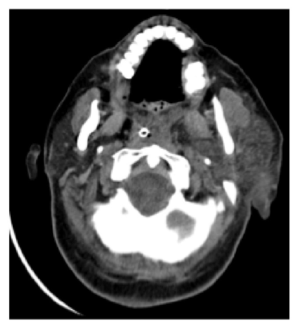

Prediction:  A computed tomography (CT) scan of the brain and surrounding structures in a patient with a suspected stroke. 



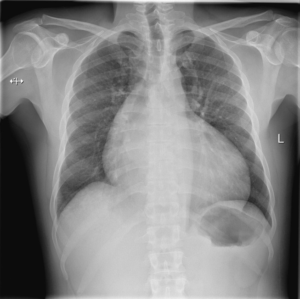

Prediction:  This is a chest x-ray of a patient with a large left heart shadow. The patient is in a seated position with the patient's head turned to the right. The heart is located in the center of the image and appears to be enlarged compared to the other structures. The lungs are visible on either side of the 



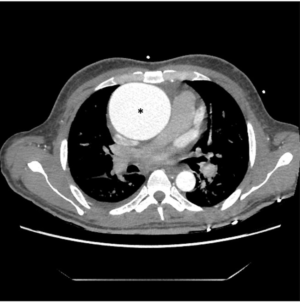

Prediction:  An axial computed tomography scan of the chest with contrast. 



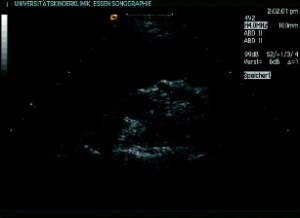

Prediction:  A screen shot shows a medical image with several lines of text. 



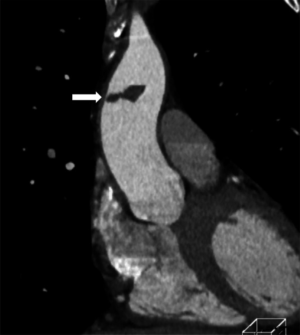

Prediction:  A black and white myocardial infarction (heart attack) image with an arrow pointing to a small area of the heart. 



In [ ]:


eval_results = run_model_evaluation(
    model,
    train_ds,          # or eval_ds
    num_samples=5,
    device='cuda',
    constant_query="What does this medical image show?"
)


## Manual Evaluation on an image

### No image splitting

In [ ]:
import torch
from PIL import Image
import requests
from torchvision.transforms.functional import to_pil_image, resize

def evaluate_image(image_url, model, processor, device='cuda'):
    model.eval()

    # Properly handle the image fetch and load
    response = requests.get(image_url, stream=True)  # Ensure the response is streamed
    response.raw.decode_content = True  # Decode the content that was streamed
    pil_image = Image.open(response.raw).convert('RGB')  # Now open it with PIL

    # Resize the image for display
    aspect_ratio = pil_image.width / pil_image.height
    new_width = 600
    new_height = int(new_width / aspect_ratio)
    display_image = resize(pil_image, (new_height, new_width))
    display_image.show()  # Display the image

    # Construct the message template
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"}, # YOU CAN COMMENT THIS OUT IF THERE ARE NO IMAGES.
                {"type": "text", "text": "What headlines do you see here?"}
            ]
        }
    ]

    # Apply the chat template to preprocess input
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=[text.strip()], images=[pil_image], return_tensors="pt", padding=True).to(device)

    # Generate output from the model
    generated_ids = model.generate(**inputs, max_new_tokens=512, temperature=0.3)
    generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

    print(f"Prediction: {generated_texts[0]}")
    return generated_texts[0]

# Example usage
image_url = "https://www.tomorrowspapers.co.uk/wp-content/uploads/2024/01/Financial-Times-18.jpg"
result = evaluate_image(image_url, model, processor)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Prediction:  Court freezes more assets as crime agency investigates PPE fraud claims.


# Training loop

We first define the data collator which takes list of samples and return input tensors fed to the model. There are 4 tensors types we are interested:
- `input_ids`: these are the input indices fed to the language model
- `attention_mask`: the attention mask for the `input_ids` in the language model
- `pixel_values`: the (pre-processed) pixel values that encode the image(s). Idefics2 treats images in their native resolution (up to 980) and their native aspect ratio
- `pixel_attention_mask`: when multiple image(s) are packed into the same sample (or in the batch), attention masks for the images are necessary because of these images can have different sizes and aspect ratio. This masking ensures that the vision encoder properly forwards the images.


In [ ]:
import torch

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        # Grab the *full* token sequence for the assistant header
        self.assist_tokens = processor.tokenizer(
            "\nAssistant:",
            add_special_tokens=False,
            return_tensors="pt"
        )["input_ids"][0]  # shape: (k,)

    def __call__(self, examples):
        texts, images = [], []

        # Build messages for every example
        for ex in examples:
            question = "What do you see here?"
            answer   = ex["caption"]
            image    = ex["image"]

            messages = [
                {"role": "user",
                 "content": [
                     {"type": "text",  "text": question},
                     {"type": "image"}
                 ]},
                {"role": "assistant",
                 "content": [
                     {"type": "text", "text": answer}
                 ]}
            ]
            text = self.processor.apply_chat_template(
                messages, add_generation_prompt=False
            )
            texts.append(text.strip())
            images.append(image)         # ← flat list

        # Tokenise the whole batch
        batch = self.processor(
            text=texts,
            images=images,
            return_tensors="pt",
            padding=True
        )

        # Prepare labels
        labels = batch["input_ids"].clone()

        for i, input_ids in enumerate(batch["input_ids"]):
            start = self._find_subseq(input_ids, self.assist_tokens)
            if start is not None:
                # mask everything *before* the assistant header
                labels[i, : start + len(self.assist_tokens)] = -100
            else:
                # rare fallback – mask all, no loss from this sample
                labels[i, :] = -100

        batch["labels"] = labels
        return batch

    @staticmethod
    def _find_subseq(sequence, subseq):
        """Return start idx of subseq in sequence or None."""
        n, m = len(sequence), len(subseq)
        for idx in range(n - m + 1):
            if torch.equal(sequence[idx : idx + m], subseq):
                return idx
        return None


In [ ]:
#show a first example
print(train_dataset[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x748 at 0x7FD154924D50>, 'caption': 'Head CT demonstrating left parotiditis.'}


In [ ]:
data_collator = MyDataCollator(processor)

In [ ]:
# ─────────────────────────────────────────────────────────────
# Quick 2‑sample debug: inspect how MyDataCollator tokenises
# and masks assistant‑only labels on the streaming train split
# ─────────────────────────────────────────────────────────────
from itertools import islice
import torch

# 1️⃣  Grab two samples safely from the streaming dataset
sample_batch = list(islice(train_dataset, 2))          # train_ds = your streaming split

# 2️⃣  Pass them through the patched collator
processed_batch = data_collator(sample_batch)

print("Processed batch keys:", processed_batch.keys())

# 3️⃣  Raw tensors
print("\ninput_ids shape:", processed_batch["input_ids"].shape)
print(processed_batch["input_ids"])

print("\nlabels shape:", processed_batch["labels"].shape)
print(processed_batch["labels"])

# 4️⃣  Decode for human‑readable inspection
print("\nDecoded full prompts:")
for ids in processed_batch["input_ids"]:
    print(processor.tokenizer.decode(ids, skip_special_tokens=False), "\n")

print("Decoded **assistant‑only** labels:")
for lbl in processed_batch["labels"]:
    keep = lbl[lbl != -100]                 # drop masked positions
    print(processor.tokenizer.decode(keep, skip_special_tokens=False), "\n")


Processed batch keys: dict_keys(['pixel_values', 'pixel_attention_mask', 'input_ids', 'attention_mask', 'labels'])

input_ids shape: torch.Size([2, 1166])
tensor([[    1, 11126,    42,  ...,     2,     2,     2],
        [    1, 11126,    42,  ..., 19678,    30, 49279]])

labels shape: torch.Size([2, 1166])
tensor([[ -100,  -100,  -100,  ...,     2,     2,     2],
        [ -100,  -100,  -100,  ..., 19678,    30, 49279]])

Decoded full prompts:
<|im_start|>User: What do you see here?<fake_token_around_image><row_1_col_1><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><fake_token_around_image><

In [ ]:
print(model)

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-11): 12 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_features=7

In [ ]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=64,                 # Rank (usually 8, 16, or 32 depending on model size and needs)
    lora_alpha=16,         # Scaling factor for the low-rank updates. Smaller for smaller models
    use_rslora=True,
    target_modules="all-linear",
    modules_to_save=["lm_head","embed_tokens"], # can help a bit with accuracy
    lora_dropout=0.1,      # Dropout for low-rank adapter layers
    bias="none",           # Bias in adapter layers: "none", "all", or "lora_only"
    task_type="CAUSAL_LM"  # Task type: "CAUSAL_LM", "SEQ_2_SEQ_LM", or "TOKEN_CLS"
)

In [ ]:
from peft import get_peft_model

model=get_peft_model(model,lora_config)

In [ ]:
model.print_trainable_parameters()

trainable params: 140,816,384 || all params: 648,298,688 || trainable%: 21.7209


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
#──────────────────────────────────────────────────────────────
# 0.  Mount Drive (skip if already mounted)
#──────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

#──────────────────────────────────────────────────────────────
# 1.  Paths & dataset (non-streaming clean copy you saved)
#──────────────────────────────────────────────────────────────
ckpt_path   = "/content/drive/MyDrive/SMOLVLM/checkpoint-2503"
data_root   = "/content"                     # adjust if you moved
#train_ds    = load_from_disk(f"{data_root}/Clef_2025_clean").cast_column("image", Image())
#eval_ds     = load_from_disk(f"{data_root}/Clef_test_2025_clean").cast_column("image", Image())


# model.gradient_checkpointing_enable()  # (optional memory saver)

#──────────────────────────────────────────────────────────────
# 3.  Same TrainingArguments (epoch-based now that dataset has len)
#──────────────────────────────────────────────────────────────
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/SMOLVLM",   # same folder as checkpoint
    run_name="smolvlm_medical_lora_ep2",
    num_train_epochs=2,                   # dataset has __len__, no max_steps needed
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,       # eff-batch 32
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    warmup_steps=500,
    bf16=True,                            # bf16 autocast, no GradScaler bug
    remove_unused_columns=False,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",

    logging_steps=100,
    dataloader_num_workers=8,
    seed=42,
)


#──────────────────────────────────────────────────────────────
# 4.  Trainer & resume
#──────────────────────────────────────────────────────────────
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ►► Continue training to step 5006
trainer.train(resume_from_checkpoint=ckpt_path)

# If you only want to **evaluate** the saved adapter without more training:
# trainer.evaluate(ckpt_path)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


	save_steps: 500 (from args) != 2503 (from trainer_state.json)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: racho1 (racho1-maryland) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,2.522900,2.585973


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


TrainOutput(global_step=5004, training_loss=1.2575244213656174, metrics={'train_runtime': 29452.6149, 'train_samples_per_second': 5.439, 'train_steps_per_second': 0.17, 'total_flos': 6.080498699312087e+17, 'train_loss': 1.2575244213656174, 'epoch': 1.9996504020376566})

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/SMOLVLM",
    run_name="smolvlm_medical_lora_ep2",

    max_steps=5006,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,     # eff‑batch 32
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    warmup_steps=500,

    fp16=False,                         # ⬅️  turn *off* fp16
    bf16=True,                          # ⬅️  enable bf16 autocast
    remove_unused_columns=False,

    eval_strategy="steps", eval_steps=2503,
    save_strategy="steps", save_steps=2503, save_total_limit=5,
    load_best_model_at_end=True, metric_for_best_model="eval_loss",

    logging_steps=100,
    dataloader_num_workers=8,
    seed=42,
)


In [ ]:
model.gradient_checkpointing_enable()     # trades compute for memory
model.enable_input_require_grads()        # PEFT guideline


In [ ]:
from transformers import EarlyStoppingCallback


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,      # still streaming
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


NameError: name 'training_args' is not defined

In [ ]:
# set cache use to false
model.config.use_cache = False

trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: racho1 (racho1-maryland) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
2503,2.613500,2.624659


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings

Step,Training Loss,Validation Loss
2503,2.613500,2.624659


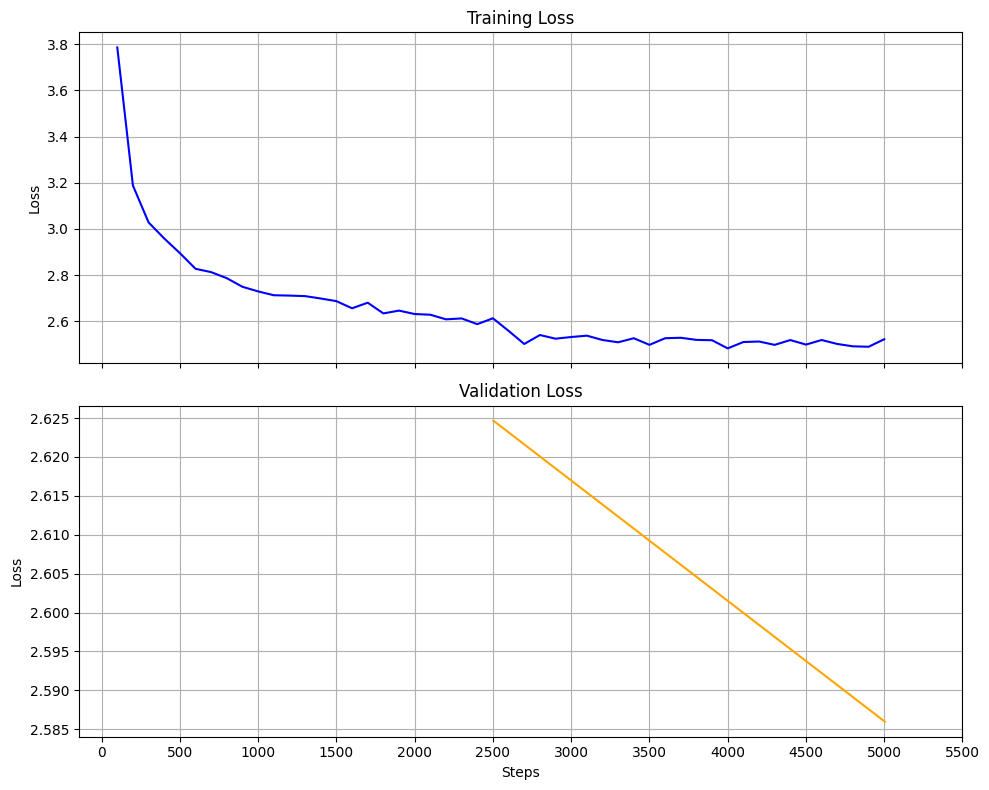

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the training history
with open('/content/drive/MyDrive/SMOLVLM/checkpoint-5004/trainer_state.json', 'r') as file:
    trainer_state = json.load(file)

# Extract loss values from the trainer_state
training_steps = []
training_losses = []
validation_steps = []
validation_losses = []

for log_entry in trainer_state['log_history']:
    if 'loss' in log_entry and 'step' in log_entry:  # This is a training loss entry
        training_steps.append(log_entry['step'])
        training_losses.append(log_entry['loss'])
    elif 'eval_loss' in log_entry and 'step' in log_entry:  # This is a validation loss entry
        validation_steps.append(log_entry['step'])
        validation_losses.append(log_entry['eval_loss'])

# Set up the plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
ax[0].plot(training_steps, training_losses, label='Training Loss', color='blue')
ax[0].set_title('Training Loss')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

# Plot validation loss
ax[1].plot(validation_steps, validation_losses, label='Validation Loss', color='orange')
ax[1].set_title('Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Steps')
ax[1].grid(True)

# Define the tick values as multiples of 1095, considering the range of your steps
tick_step = 500
xticks = range(0, max(max(training_steps, default=0), max(validation_steps, default=0)) + tick_step, tick_step)
ax[1].set_xticks(xticks)  # Set x-ticks on both subplots

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from transformers import TrainingArguments, Trainer

# for main fine-tuning
epochs=2
lr=0.5e-3
schedule="constant"

# # Optional, for annealing - just re-run the training again after having run with the main settings.
# epochs=0.4
# lr=0.5e-3
# schedule="linear"

run_name=f"trelis-chess-{lr}_lr-{epochs}_epochs-{schedule}_schedule-completions-only-annealing"

training_args = TrainingArguments(
    max_steps=4,
    num_train_epochs=epochs,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    # warmup_steps=50, #comment in only if you have a lot more than 50 samples.
    learning_rate=lr,
    weight_decay=0.01,
    logging_steps=0.1,
    output_dir="fine-tuned-model",
    eval_strategy="steps",
    eval_steps=0.2,
    lr_scheduler_type=schedule,
    # save_strategy="steps",
    # save_steps=250,
    # save_total_limit=1,
    # fp16=True, #if using Colab, but then you need to use bitsandbytes quantization too.
    bf16=True,
    hub_model_id="Trelis/SmolVLM-500M-chess",
    remove_unused_columns=False,
    report_to="tensorboard",
    run_name=run_name,
    logging_dir=f"./logs/{run_name}",
    gradient_checkpointing=True, #should reduce VRAM requirements a lot
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
)

# TIP
# It can be nice to train with a constant learning rate, keep repeating that til the eval loss is flattening, then train for some steps with linear decay/annealing.

# Training and pushing to the hub

We have all the core building blocks now, so we fine-tune the model!

The training can take a few minutes depending on the hardware you use.

In [ ]:
# set cache use to false
model.config.use_cache = False

trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
1,1.641500,2.169432
2,1.109100,2.109094
3,1.653000,2.054115
4,0.906600,2.026232


TrainOutput(global_step=4, training_loss=1.327542558312416, metrics={'train_runtime': 37.6222, 'train_samples_per_second': 0.425, 'train_steps_per_second': 0.106, 'total_flos': 47159702578176.0, 'train_loss': 1.327542558312416, 'epoch': 0.3333333333333333})

# Evaluation

Let's evaluate the model. First, we can have a look at a qualitative generation from the model.

In [ ]:
#──────────────────────────────────────────────────────────────
# 0.  Configuration
#──────────────────────────────────────────────────────────────
HF_DATASET_ID = "racho1/test_dataset"   # ← HF repo containing test images
TEST_SPLIT    = "test"                          # e.g. "test" or "unseen"

CKPT_PATH     = "/content/drive/MyDrive/SMOLVLM/checkpoint-5004"   # best adapter
CSV_OUT       = "/content/drive/MyDrive/SMOLVLM/hf_test_predictions.csv"
PROMPT_TEXT   = "Describe the medical image."

#──────────────────────────────────────────────────────────────
# 1.  Load model + adapter  (bfloat16 for A100)
#──────────────────────────────────────────────────────────────
from transformers import AutoModelForCausalLM, AutoProcessor
from peft import PeftModel
import torch, csv
from datasets import load_dataset, Image

device = "cuda"

#base = AutoModelForCausalLM.from_pretrained(
           #"microsoft/SmolVLM-500M", torch_dtype=torch.bfloat16
       #).to(device).eval()
model = PeftModel.from_pretrained(base, CKPT_PATH).eval()
processor = AutoProcessor.from_pretrained("microsoft/SmolVLM-500M")

#──────────────────────────────────────────────────────────────
# 2.  Stream unseen test split from the Hub
#──────────────────────────────────────────────────────────────
test_ds = load_dataset(
            HF_DATASET_ID,
            split=TEST_SPLIT,
            streaming=True,         # keeps RAM tiny
            verification_mode="no_checks"
         ).cast_column("image", Image())

#──────────────────────────────────────────────────────────────
# 3.  Caption helper
#──────────────────────────────────────────────────────────────
def caption_image(pil_img):
    messages = [
        {"role":"user",
         "content":[
            {"type":"text","text": PROMPT_TEXT},
            {"type":"image"}
         ]}
    ]
    chat = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=[chat], images=[pil_img],
                       return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        gen = model.generate(**inputs, max_new_tokens=64)
    return processor.decode(gen[0, inputs["input_ids"].size(1):],
                             skip_special_tokens=True).strip()

#──────────────────────────────────────────────────────────────
# 4.  Iterate & save captions
#──────────────────────────────────────────────────────────────
results = []
for ex in test_ds:
    # every record must have an image; keep a filename/id if available
    img  = ex["image"]
    img_id = ex.get("id") or ex.get("file_name") or "unknown"
    try:
        cap = caption_image(img)
        print(f"{img_id[:30]}  →  {cap}")
        results.append((img_id, cap))
    except Exception as e:
        print("⚠️  failed on", img_id, ":", e)

with open(CSV_OUT, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_id", "generated_caption"])
    writer.writerows(results)

print(f"\n📝  Captions saved to {CSV_OUT}  (total {len(results)} images)")


OSError: microsoft/SmolVLM-500M is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
#─────────────────────────────────────────────────────────────
# 0.  Paths
#─────────────────────────────────────────────────────────────
ckpt_path   = "/content/drive/MyDrive/SMOLVLM/checkpoint-5004"   # best checkpoint
test_folder = "/content/unseen_test_images"                     # your images
csv_out     = "/content/unseen_predictions.csv"

#─────────────────────────────────────────────────────────────
# 1.  Load model + adapter (bfloat16 for A100)
#─────────────────────────────────────────────────────────────
from transformers import AutoModelForCausalLM, AutoProcessor
from peft import PeftModel
import torch, os, csv
from PIL import Image

device = "cuda"

base = AutoModelForCausalLM.from_pretrained(
         "microsoft/SmolVLM-500M",
         torch_dtype=torch.bfloat16
       ).to(device).eval()

model = PeftModel.from_pretrained(base, ckpt_path).eval()
processor = AutoProcessor.from_pretrained("microsoft/SmolVLM-500M")

#─────────────────────────────────────────────────────────────
# 2.  Helper: caption one PIL.Image
#─────────────────────────────────────────────────────────────
def caption_image(pil_img, prompt="Describe the medical image."):
    messages = [
        {"role":"user","content":[
            {"type":"text","text":prompt},
            {"type":"image"}   # placeholder
        ]}
    ]
    chat = processor.apply_chat_template(messages, add_generation_prompt=True)

    inputs = processor(
        text=[chat],
        images=[pil_img],
        return_tensors="pt",
        padding=True
    ).to(device)

    with torch.no_grad():
        gen = model.generate(**inputs, max_new_tokens=64)
    caption = processor.decode(
        gen[0, inputs["input_ids"].size(1):],
        skip_special_tokens=True
    )
    return caption.strip()

#─────────────────────────────────────────────────────────────
# 3.  Iterate through unseen images and save captions
#─────────────────────────────────────────────────────────────
results = []
for fname in sorted(os.listdir(test_folder)):
    if not fname.lower().endswith((".jpg",".jpeg",".png",".tif",".bmp")):
        continue
    img_path = os.path.join(test_folder, fname)
    try:
        img = Image.open(img_path).convert("RGB")
        cap = caption_image(img, prompt="What does this medical image show?")
        print(f"{fname}  →  {cap}")
        results.append((fname, cap))
    except Exception as e:
        print("⚠️ ", fname, "failed:", e)

# save to CSV
with open(csv_out, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_id", "generated_caption"])
    writer.writerows(results)

print(f"\n📝 Captions saved to {csv_out}  (total {len(results)} images)")


Test Prediction

In [ ]:
from transformers import AutoProcessor
from peft import PeftModel
from transformers import AutoModelForVision2Seq

from datasets import load_dataset, Image
import torch
import csv

#──────────────────────────────────────────────────────────────
# Configuration
#──────────────────────────────────────────────────────────────
HF_DATASET_ID = "racho1/test_dataset"     # your dataset on HF Hub
TEST_SPLIT    = "test"                    # dataset split name
CKPT_PATH     = "/content/drive/MyDrive/SMOLVLM/checkpoint-5004"  # your LoRA checkpoint
BASE_MODEL    = "HuggingFaceTB/SmolVLM-500M-Instruct"              # base model with LoRA injected
CSV_OUT       = "/content/drive/MyDrive/SMOLVLM/test_predictions.csv"
PROMPT_TEXT   = "Describe the medical image."

device = "cuda" if torch.cuda.is_available() else "cpu"

#──────────────────────────────────────────────────────────────
# Load model and processor
#──────────────────────────────────────────────────────────────
base_model = AutoModelForVision2Seq.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)


model = PeftModel.from_pretrained(base_model, CKPT_PATH).eval()
processor = AutoProcessor.from_pretrained(BASE_MODEL)

#──────────────────────────────────────────────────────────────
# Load test dataset
#──────────────────────────────────────────────────────────────
test_ds = load_dataset(
    HF_DATASET_ID,
    split=TEST_SPLIT,
    streaming=True,
    verification_mode="no_checks"
).cast_column("image", Image())

#──────────────────────────────────────────────────────────────
# Caption generation helper
#──────────────────────────────────────────────────────────────
def caption_image(pil_img):
    messages = [
        {"role": "user", "content": [
            {"type": "text", "text": PROMPT_TEXT},
            {"type": "image"}
        ]}
    ]
    chat = processor.apply_chat_template(messages, add_generation_prompt=True)

    inputs = processor(
        text=[chat],
        images=[pil_img],
        return_tensors="pt",
        padding=True
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=64)

    response = processor.decode(
        output_ids[0, inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    ).strip()

    return response

#──────────────────────────────────────────────────────────────
# Inference and CSV writing
#──────────────────────────────────────────────────────────────
results = []

print("⏳ Generating captions...")
for idx, ex in enumerate(test_ds):
    try:
        image = ex["image"]
        img_id = ex.get("id") or ex.get("file_name") or f"image_{idx}"

        caption = caption_image(image)
        print(f"{img_id[:30]} → {caption}")
        results.append((img_id, caption))

    except Exception as e:
        print(f"⚠️ Failed on {img_id}: {e}")

# Save to CSV
with open(CSV_OUT, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_id", "generated_caption"])
    writer.writerows(results)

print(f"\n✅ Captions saved to {CSV_OUT} (Total: {len(results)} images)")


README.md:   0%|          | 0.00/328 [00:00<?, ?B/s]

⏳ Generating captions...
image_0 → MRI of the pelvis showing a large mass in the right inguinal region.
image_1 → MRI of the brain showing a hyperintense lesion in the right frontal lobe (asterisk)
image_2 → CT scan of the abdomen and pelvis showing a large mass in the right lower quadrant (arrow).
image_3 → Axial T1-weighted MRI image showing a large mass lesion in the left temporal lobe (arrow).
image_4 → Sagittal T2-weighted MRI of the cervical spine showing a large, well-defined, hyperintense mass in the posterior aspect of the C2-C3 vertebral bodies.
image_5 → Sagittal T2-weighted MRI of the cervical spine showing a large, well-defined, hyperintense mass in the C2-C3 region (red arrows).
image_6 → Barium enema showing a small amount of contrast in the rectum (green arrow).
image_7 → Axial T2-weighted MRI image showing a large, well-defined, heterogeneous mass in the right posterior cervical spine.
image_8 → Transthoracic echocardiogram showing a large pericardial effusion (white a

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Streaming output truncated to the last 5000 lines.
image_14269 → CT scan of the abdomen and pelvis showing a large right-sided retroperitoneal mass.
image_14270 → Postoperative radiograph of the right ankle.
image_14271 → Panoramic radiograph showing the presence of a 1.5-mm radiolucent lesion in the right mandibular ramus.
image_14272 → Panoramic radiograph showing the implant in the right mandibular condyle.
image_14273 → Transthoracic echocardiogram showing a large pericardial effusion.
image_14274 → Magnetic resonance angiography of the legs showing no evidence of vascular disease.
image_14275 → Ultrasound image of the liver showing a large cystic lesion with a well-defined solid component (arrows).
image_14276 → CT scan of the abdomen showing a 10.3 cm × 8.7 cm mass in the right lobe of the liver.
image_14277 → Measurement of the acetabular angle (A) and the acetabular-femoral angle (B) on an anteroposterior radiograph of the pelvis.
image_14278 → CT scan of the head and neck show

In [ ]:
import pandas as pd
from PIL import Image

# Load classification results
df = pd.read_csv("/content/test_predictions_Final.csv")

# Add full image path
df["image_path"] = "/content/test_images/" + df["ID"]

# Create caption prompt using the image type
df["prompt"] = df["Predicted"].apply(lambda x: f"This is a {x} scan. Describe the image in detail.")


In [ ]:
print("Sample IDs from CSV:", df_class["image_id"].head(5).tolist())


Sample IDs from CSV: ['ImageCLEFmedical_Caption_2025_test_0', 'ImageCLEFmedical_Caption_2025_test_1', 'ImageCLEFmedical_Caption_2025_test_2', 'ImageCLEFmedical_Caption_2025_test_3', 'ImageCLEFmedical_Caption_2025_test_4']


Test wuth label

In [ ]:
import pandas as pd
import torch
from PIL import Image
from datasets import load_dataset, Image as HFImage
from transformers import AutoProcessor
from peft import PeftModel
from transformers import AutoModelForVision2Seq
import csv

#──────────────────────────────────────────────────────────────
# Configuration
#──────────────────────────────────────────────────────────────
HF_DATASET_ID = "racho1/test_dataset"
TEST_SPLIT    = "test"
CLASS_CSV     = "/content/test_predictions_Final.csv"
CKPT_PATH     = "/content/drive/MyDrive/SMOLVLM/checkpoint-5004"
BASE_MODEL    = "HuggingFaceTB/SmolVLM-500M-Instruct"
CSV_OUT       = "/content/drive/MyDrive/SMOLVLM/newtest_predictions.csv"

device = "cuda" if torch.cuda.is_available() else "cpu"

#──────────────────────────────────────────────────────────────
# Load and clean classification CSV
#──────────────────────────────────────────────────────────────
df_class = pd.read_csv(CLASS_CSV)
df_class = df_class.rename(columns={"ID": "image_id", "predicted_label": "type"})
df_class["image_id"] = df_class["image_id"].astype(str).str.strip() + ".jpg"
df_class["type"] = df_class["type"].astype(str).str.strip().str.capitalize()

# Dictionary: image_id → label
type_map = dict(zip(df_class["image_id"], df_class["type"]))

#──────────────────────────────────────────────────────────────
# Load Hugging Face test dataset
#──────────────────────────────────────────────────────────────
dataset = load_dataset(
    HF_DATASET_ID,
    split=TEST_SPLIT,
    streaming=False,
    verification_mode="no_checks"
).cast_column("image", HFImage())

#──────────────────────────────────────────────────────────────
# Load model and processor
#──────────────────────────────────────────────────────────────
base_model = AutoModelForVision2Seq.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model = PeftModel.from_pretrained(base_model, CKPT_PATH).eval()
processor = AutoProcessor.from_pretrained(BASE_MODEL)

#──────────────────────────────────────────────────────────────
# Generate caption with neutral prompt
#──────────────────────────────────────────────────────────────
def caption_image(pil_img):
    messages = [
        {"role": "user", "content": [
            {"type": "text", "text": "Describe the medical image."},
            {"type": "image"}
        ]}
    ]
    chat = processor.apply_chat_template(messages, add_generation_prompt=True)

    inputs = processor(
        text=[chat],
        images=[pil_img],
        return_tensors="pt",
        padding=True
    ).to(device)

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=64)

    start = inputs["input_ids"].shape[1]
    if output.shape[1] <= start:
        return "[No caption generated]"

    response = processor.decode(output[0, start:], skip_special_tokens=True).strip()
    return response

#──────────────────────────────────────────────────────────────
# Clean hallucinated modality from model output
#──────────────────────────────────────────────────────────────
def remove_hallucinated_modality(caption, correct_label):
    modalities = ["MRI", "CT", "Radiograph", "Ultrasound"]
    words = caption.strip().split()

    if len(words) == 0:
        return caption

    first_word = words[0].lower()
    if first_word in [m.lower() for m in modalities]:
        # Remove first word
        words = words[1:]
        # Also remove "scan" or "image" if it's the next word
        if words and words[0].lower() in ["scan", "image"]:
            words = words[1:]
    return " ".join(words).strip()

#──────────────────────────────────────────────────────────────
# Inference loop
#──────────────────────────────────────────────────────────────
results = []

print("⏳ Generating captions...")
for idx, example in enumerate(dataset):
    image = example["image"]
    image_id = f"ImageCLEFmedical_Caption_2025_test_{idx}.jpg"

    if image_id not in type_map:
        print(f"⚠️ Skipping unknown image_id: {image_id}")
        continue

    label = type_map[image_id]

    try:
        print(f"📌 {image_id} ← Label: {label}")
        generated_caption = caption_image(image)
        cleaned_caption = remove_hallucinated_modality(generated_caption, label)
        final_caption = f"{label} showing {cleaned_caption}"
        print(f"✅ {image_id} → {final_caption}")
        results.append((image_id, label, final_caption))

    except Exception as e:
        print(f"❌ Failed on {image_id}: {e}")

#──────────────────────────────────────────────────────────────
# Save to CSV
#──────────────────────────────────────────────────────────────
with open(CSV_OUT, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_id", "type", "generated_caption"])
    writer.writerows(results)

print(f"\n✅ Captions saved to {CSV_OUT} (Total: {len(results)} images)")


⏳ Generating captions...
📌 ImageCLEFmedical_Caption_2025_test_0.jpg ← Label: Radiograph
✅ ImageCLEFmedical_Caption_2025_test_0.jpg → Radiograph showing of the pelvis showing a large mass in the right inguinal region.
📌 ImageCLEFmedical_Caption_2025_test_1.jpg ← Label: Radiograph
✅ ImageCLEFmedical_Caption_2025_test_1.jpg → Radiograph showing of the brain showing a hyperintense lesion in the right frontal lobe (asterisk)
📌 ImageCLEFmedical_Caption_2025_test_2.jpg ← Label: Ct
✅ ImageCLEFmedical_Caption_2025_test_2.jpg → Ct showing of the abdomen and pelvis showing a large mass in the right lower quadrant (arrow).
📌 ImageCLEFmedical_Caption_2025_test_3.jpg ← Label: Radiograph
✅ ImageCLEFmedical_Caption_2025_test_3.jpg → Radiograph showing Axial T1-weighted MRI image showing a large mass lesion in the left temporal lobe (arrow).
📌 ImageCLEFmedical_Caption_2025_test_4.jpg ← Label: Radiograph
✅ ImageCLEFmedical_Caption_2025_test_4.jpg → Radiograph showing Sagittal T2-weighted MRI of the cerv

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Streaming output truncated to the last 5000 lines.
📌 ImageCLEFmedical_Caption_2025_test_16768.jpg ← Label: Mri
✅ ImageCLEFmedical_Caption_2025_test_16768.jpg → Mri showing Panoramic radiograph showing a radiolucent lesion in the right mandibular condyle (green arrow).
📌 ImageCLEFmedical_Caption_2025_test_16769.jpg ← Label: Ultrasound
✅ ImageCLEFmedical_Caption_2025_test_16769.jpg → Ultrasound showing of the mass. The mass is located in the subcutaneous tissue of the left upper arm. The mass is hypoechoic and has a well-defined border. The mass is located in the subcutaneous tissue of the left upper arm. The mass is hypoechoic and has a well-defined border.
📌 ImageCLEFmedical_Caption_2025_test_16770.jpg ← Label: Ct
✅ ImageCLEFmedical_Caption_2025_test_16770.jpg → Ct showing of the abdomen showing a large mass in the right lobe of the liver (red arrow).
📌 ImageCLEFmedical_Caption_2025_test_16771.jpg ← Label: Ct
✅ ImageCLEFmedical_Caption_2025_test_16771.jpg → Ct showing Coronal CT image 